# ARIMA'yı Ayrıştırma ile Birleştirmek

Basit bir ARIMA modeli sürecini zaten ele almıştık. Bu alıştırmada, derste gördüğünüz `seasonal decompose` aracıyla bir ARIMA modelinin kombinasyonunu kullanarak bu konuyu biraz daha geliştireceğiz. Mevsimsellikle __özel olarak__ başa çıkmak için kullanabileceğimiz modeller var, ancak burada adım adım ilerleyerek bu zaman serisini manuel olarak parçalayacağız, böylece onu tam olarak anlayacağız ve TS verileriyle çalışırken karşılaşabileceğimiz sorunları öğreneceğiz.

Bu challenge için günlük CO2 ppm ölçümleriyle çalışacağız, özellikle Mauna Loa Gözlemevi'nden alınan günlük CO2 ölçümleriyle 🌋

Bu ölçümler 1958'den beri alınıyor ve iklim biliminin temel taşlarından biri. Hawaii'de 3.000 metreden fazla yükseklikte konumlanmış olan gözlemevi, yerel emisyonlardan büyük ölçüde uzak olarak küresel atmosferik karbon seviyelerini izlemek için ideal bir konumdadır. Kayıtlar sağlam olmasına rağmen, __ara sıra enstrüman sorunları veya aşırı hava koşulları nedeniyle boşluklar içermektedir__, araştırmacılar bu kritik veri setinin bütünlüğünü korumak için analizlerinde bunları hesaba katmalıdır. 1974'ten beri __neredeyse__ günlük olarak alınan verilerin bir kısmını kullanacağız - notebook boyunca verilerdeki boşlukları ele alacağız!

Laboratuvarın yaptığı iklim çalışmaları hakkında merak ediyorsanız, buradan daha fazla bilgi edinebilirsiniz: https://gml.noaa.gov/ccgg/about/co2_measurements.html

## Veriyi Yükleme ve Keşfetme

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("https://d32aokrjazspmn.cloudfront.net/materials/co2_daily_mlo.csv")

In [3]:
df

,year,month,day,CO2 molfrac (ppm)
0,1974,5,17,333.38
1,1974,5,18,333.11
2,1974,5,19,333.46
3,1974,5,20,333.64
4,1974,5,21,333.50
...,...,...,...,...
15191,2023,10,19,419.44
15192,2023,10,20,419.53
15193,2023,10,21,418.90
15194,2023,10,23,419.09


Verilerin çalışmamız için pek güzel formatlanmadığını görebiliyoruz, bu yüzden önce `pd.to_datetime()` kullanarak bu adımı çözelim (bu fonksiyonu aynı anda birden fazla sütunda kullanabilirsiniz 👀). Daha fazla bilgi için [dokümanları](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) kontrol edin.

Doğru şekilde formatladıktan sonra, bunu index olarak ayarlayın.

In [4]:
df["date"] = pd.to_datetime(df[['year', 'month', 'day']])
df.drop(["year", "month", "day"], inplace = True, axis = 1)
df.set_index("date", inplace = True)

CO2 değerlerinizi çizdirin ve partnerinizle ne gördüğünüzü tartışın. Verilerinizde herhangi bir boşluk var gibi görünüyor mu? __Emin misiniz__? DataFrame'inizin ilk 50 değerini kontrol edin

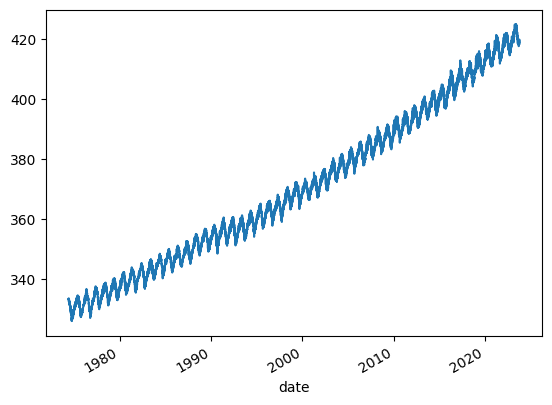

In [5]:
df["CO2 molfrac (ppm)"].plot();

In [6]:
df.head(50)

,CO2 molfrac (ppm)
date,
1974-05-17,333.38
1974-05-18,333.11
1974-05-19,333.46
1974-05-20,333.64
1974-05-21,333.50
1974-05-22,333.21
1974-05-23,333.05
1974-05-26,333.32
1974-05-27,332.79


Bazı tarihleri kaybetmişiz 😱 Açık `NaN` değerlerimiz olmasa da, index'imizde eksik tarihler var. Bu, TS verileriyle çalışırken __gerçekten__ dikkatli olmanız gereken bir şey.

Kaç gün eksik olduğumuzu hesaplayalım. Bitiş tarihinizi (`index`'inizin `max()`'ı) başlangıç tarihinizden (`index`'inizin `min()`'ı) çıkararak ikisi arasında kaç gün __olması gerektiğini__ görelim.

In [7]:
day_diff = (df.index.max() - df.index.min()).days
day_diff

18057

Bu, DataFrame'imizde __gerçekten__ sahip olduğumuz gün sayısından nasıl farklı? Cevabınızı `missing` değişkenine kaydedin

In [8]:
missing = day_diff - df.shape[0]

In [9]:
from nbresult import ChallengeResult

result = ChallengeResult('missing',
                         missing = missing)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_missing.py::TestMissing::test_missing PASSED                        [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/missing.pickle

git commit -m 'Completed missing step'

git push origin master



Eksik değerlerin gerçekte nerede olduğunu görelim. Sahip __olmamız gereken__ index'i oluşturmak için `pd.date_range` kullanın. Ardından DataFrame'in `.reindex()` fonksiyonunu bu yeni tarih aralığıyla kullanarak ilk 100 girişimizde null değerlerin gerçekte nerede olduğunu görün!

<Axes: >

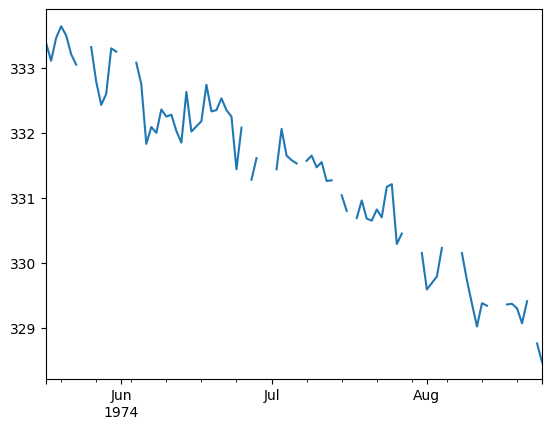

In [10]:
correct_index = pd.date_range(start=df.index.min(), end=df.index.max())
df = df.reindex(correct_index)
df["CO2 molfrac (ppm)"][:100].plot()

Buradaki en basit seçenek, çok kullanışlı olan `pd.interpolate("linear")` fonksiyonunu kullanarak bunları bizim için doldurmak. Ne yaptığını görmek için aşağıdaki hücreyi çalıştırmayı deneyin:

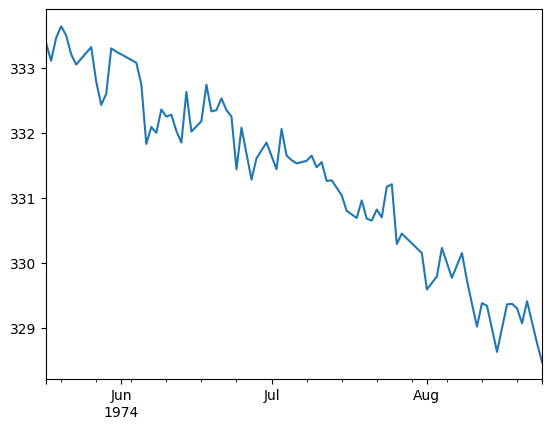

In [11]:
df["CO2 molfrac (ppm)"][:100].interpolate("linear").plot();

Interpolation bizim için noktaları bağlamak için basit bir doğrusal yöntem kullanır 😊 Tabii ki bu mükemmel olmayan bazı varsayımlar yapıyor ve aslında günlük örneklere ihtiyacımız yok - bunun yerine DataFrame'imizi aylık bazda `resample` edeceğiz ve bunu modellemeye çalışacağız. Her ayın ortalamasını içeren bir DataFrame oluşturmak için `.resample()` fonksiyonunu kullanmayı deneyin ve bunu `monthly` olarak adlandırın. [Dokümanları](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) burada görün.

In [12]:
monthly = df.resample("ME").mean()

Eğer __hala__ kalan null değerleriniz varsa, bunları doldurmak için `interpolate` kullanabilirsiniz. Yeniden örneklenmiş verilerinizi çizdirin:

<Axes: >

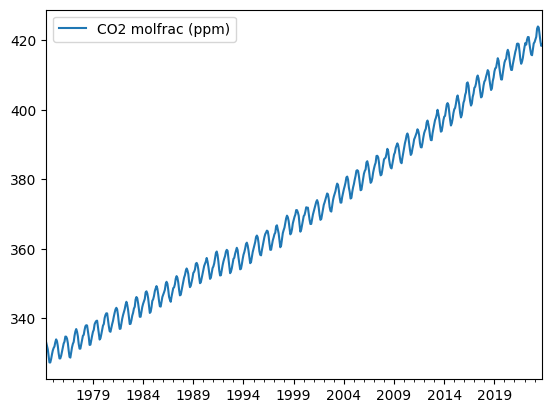

In [13]:
monthly = monthly.interpolate("linear")
monthly.plot()

<Axes: >

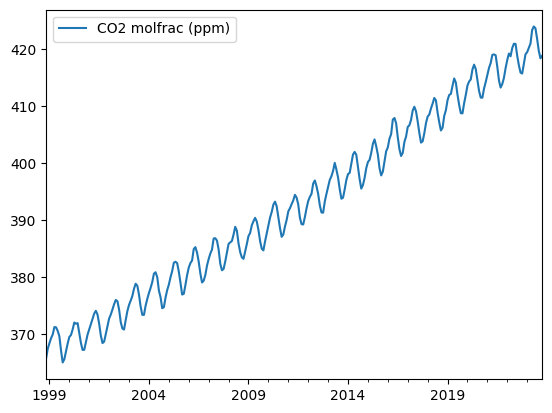

In [14]:
monthly[-300:].plot()

In [15]:
monthly["CO2 molfrac (ppm)"].iloc[0]

333.1569230769231

In [16]:
from nbresult import ChallengeResult

result = ChallengeResult('monthly',
                         monthly = monthly)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_monthly.py::TestMonthly::test_first_value PASSED                    [ 50%]
test_monthly.py::TestMonthly::test_missing PASSED                        [100%]

============================== 2 passed in 0.63s ===============================


💯 You can commit your code:

git add tests/monthly.pickle

git commit -m 'Completed monthly step'

git push origin master



## Eğitim Test Ayrımı

Şimdi eğitim ve test kümelerine ayırmamız gerekiyor (%80:%20 ayrımı yapacağız). Bunu yaparken dikkatli olun - kümelerimizin __sürekli__ olması gerekiyor!

In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(monthly, test_size=0.2, shuffle=False)

Veri hazırlığımız neredeyse bitti. Ancak ayrıştırma ve modellemeye başlamadan önce, modelimizin nasıl performans gösterdiğini görmek için bir baseline oluşturmalıyız.

Seçeceğimiz tipik baseline, bize mevcut olan son değeri tahmin etmektir. Bizim durumumuzda, bu sadece `train` DataFrame'imizdeki son noktadır.

`test` DataFrame'inizde `naive_preds` adında bir sütun oluşturun ve bunu `train`'deki son mevcut veri noktamıza eşit olarak ayarlayın


In [18]:
test["naive_preds"] = train.iloc[-1,0]

Bunu yaptıktan sonra, iki sütun arasındaki ortalama mutlak hatayı hesaplayın ve bunu `baseline_mae` olarak ayarlayın.

In [19]:
baseline_mae = (test["CO2 molfrac (ppm)"] - test["naive_preds"]).abs().mean()

In [20]:
from nbresult import ChallengeResult

result = ChallengeResult('baseline',
                         test = test,
                         baseline_mae = baseline_mae)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 3 items

test_baseline.py::TestBaseline::test_baseline_mae PASSED                 [ 33%]
test_baseline.py::TestBaseline::test_first_value PASSED                  [ 66%]
test_baseline.py::TestBaseline::test_missing PASSED                      [100%]

=============================== warnings summary ===============================
test_baseline.py::TestBaseline::test_first_value
  /Users/dilay/Desktop/S17D4-S-arima-seasonal/tests/test_baseline.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

## Modellemeye Hazırlanmak

Bazı Zaman Serisi modelleriyle, verilerimizi modele atabilir ve onun bizim için ayrıştırmasını, durağan hale getirmesini ve sonra modellemesini umabiliriz (SARIMAX veya TBATS bunun iyi örnekleridir), ancak bunun yerine adım adım ilerleyeceğiz. Mevsimsellik ve trendi bizim için kaldıracak bir modele güvenmediğimiz için, bunları kendimiz halledeceğiz.

Derste gördüğünüz `seasonal_decompose` aracını import edin ve Zaman Serinizde her iki yöntemi de deneyin (hem "multiplicative" hem "additive").

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
multi = seasonal_decompose(train, model = "multiplicative")

In [23]:
add = seasonal_decompose(train, model = "additive")

Her ikisinden de residualleri (`.resid` attribute'una erişin) çizdirin ve unutmayın - zamandan mümkün olduğunce __etkilenmemiş__ görünen olanı istiyoruz

<Axes: >

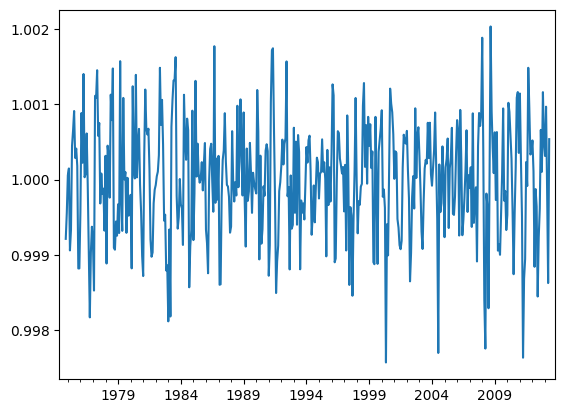

In [24]:
multi.resid.plot()

<Axes: >

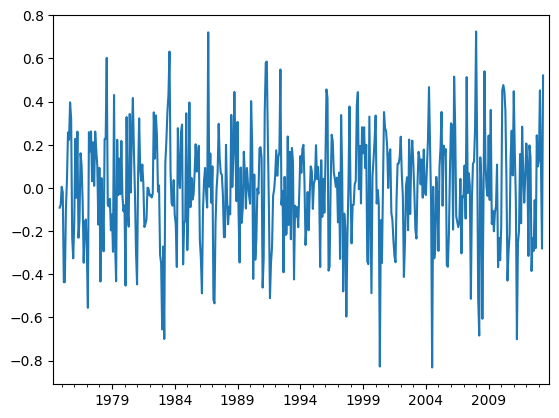

In [25]:
add.resid.plot()

Her ikisi de makul ölçüde durağan göründüğü için, multiplicative modeli seçeceğiz.

Şimdi stratejimiz zaman serimizin mevsimsel bileşenini çıkarmak.

Bunu nasıl yapabiliriz? 🤔


İlk olarak, `train` DataFrame'inizde zaman serinizin `.seasonal` bileşeniyle doldurulmuş `"seasonal_component"` adında bir sütun oluşturun.

Bunu yaptıktan sonra, sadece mevsimsel bileşenlerinizin __bir yılını__ içeren (yani `seasonal components` sütununuzun ilk 12 satırı) ayrı, daha küçük bir DataFrame oluşturun. Bu daha sonra bizim için yararlı olacak. Bunu `seasonal_one_year` olarak adlandırın ve karşılık gelen `index.month`'a eşit bir `"month"` sütununuz olduğundan emin olun (örneğin, Ocak mevsimsel bileşenine sahip bir satırınız ve yanında 1 olsun).

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/seasonal_component_one.png">

In [26]:
train["seasonal_component"] = multi.seasonal
seasonal_one_year = train[["seasonal_component"]][:12]
seasonal_one_year["month"] = seasonal_one_year.index.month

Bu multiplicative bir modelden geldiği için, bu mevsimsel bileşeni __kaldırmak__ istiyorsak, orijinal zaman serimizi bu tekrarlanan (12 aylık döngü) değerlere __bölmemiz__ gerekecek.

In [27]:
from nbresult import ChallengeResult

result = ChallengeResult('seasonal',
                         train = train,
                         seasonal = seasonal_one_year)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_seasonal.py::TestSeasonal::test_seasonal_column PASSED              [ 50%]
test_seasonal.py::TestSeasonal::test_seasonal_year_shape PASSED          [100%]

============================== 2 passed in 0.56s ===============================


💯 You can commit your code:

git add tests/seasonal.pickle

git commit -m 'Completed seasonal step'

git push origin master



Orijinal zaman serinizin değerini mevsimsel bileşene bölen `"seasonal_stripped"` adında yeni bir sütun oluşturun.

In [28]:
train["seasonal_stripped"]  = train["CO2 molfrac (ppm)"] / multi.seasonal

Bu yeni sütunu çizdirin:

<Axes: >

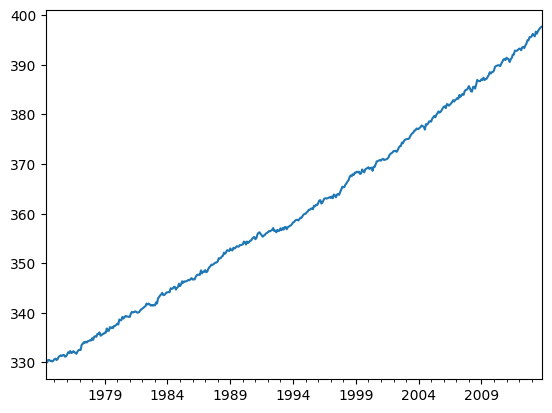

In [29]:
train["seasonal_stripped"].plot()

Henuz durağan görünüyor mu? Günün arkadaşınızla neden öyle olduğunu veya olmadığını tartışın.

Bir sonraki görevimiz bu __mevsimsellikten arındırılmış__ zaman serisini alıp durağan hale getirmek. `.diff()` kullanmayı deneyin ve nasıl göründüğüne bakın. Sonra herhangi bir değişiklik görmek için bir kez daha diff yapmayı deneyin.

<Axes: >

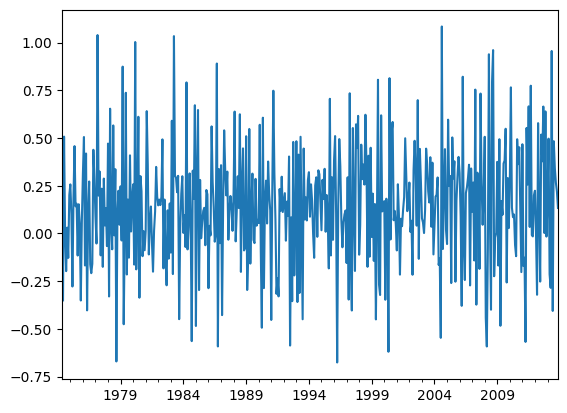

In [30]:
train["seasonal_stripped"].diff().plot()

<Axes: >

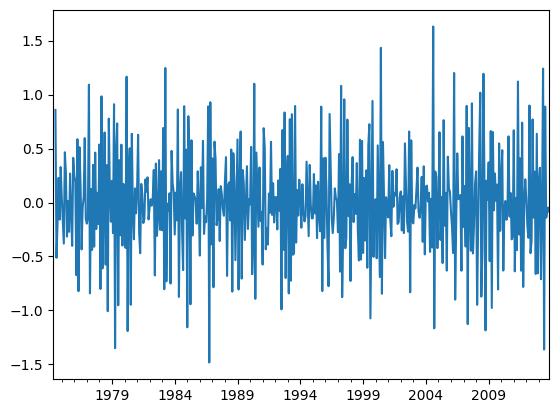

In [31]:
train["seasonal_stripped"].diff().diff().plot()

Her ikisi de görsel olarak oldukça durağan görünmeli, her birinin durağan olduğunu doğrulamak için derste gördüğünüz `adfuller` (Augmented Dicky-Fuller) testini kullanın.

Not: `diff` yaptığınızda DataFrame'inizde null değerler oluşturursunuz, ADF testi yapmak için bunları düşürmeniz gerekir.

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
diff_1_test = adfuller(train["seasonal_stripped"].diff().dropna())
print(diff_1_test)

(-5.3268446481873335, 4.816418008792554e-06, 18, 455, {'1%': -3.4448040131772584, '5%': -2.8679131843980197, '10%': -2.5701646673107112}, 203.21595261232812)


In [34]:
diff_2_test = adfuller(train["seasonal_stripped"].diff().diff().dropna())
print(diff_2_test)

(-12.670871125921398, 1.245373877061461e-23, 13, 459, {'1%': -3.4446773373329576, '5%': -2.8678574606780654, '10%': -2.5701349669405404}, 228.05020465639086)


Her ikisi de makul ölçüde durağan görünüyor ve aşırı differencing'e gerek yok gibi görünüyor (yine de daha sonra iki kez diff yapılmış bir zaman serisi oluşturmayı her zaman deneyebiliriz). Hadi `acf` ve `pacf` grafiklerimizi çizmeye devam edelim (herhangi bir `null` değeri düşürdüğünüzden emin olun - bunlar ACF ve PACF hesaplayıcılarınızı bozar) 😔

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

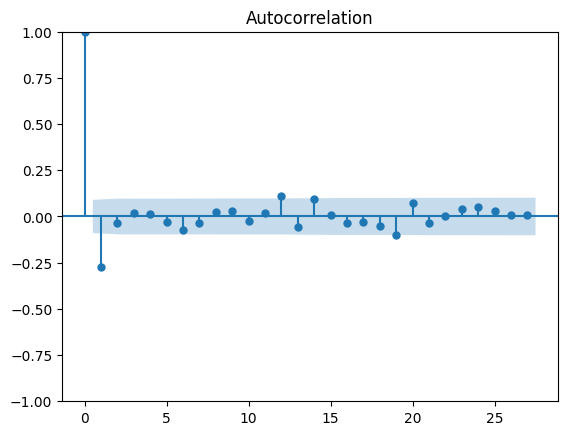

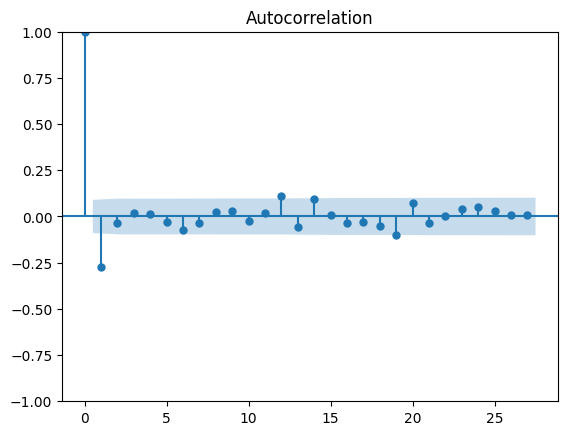

In [36]:
plot_acf(train["seasonal_stripped"].diff().dropna())

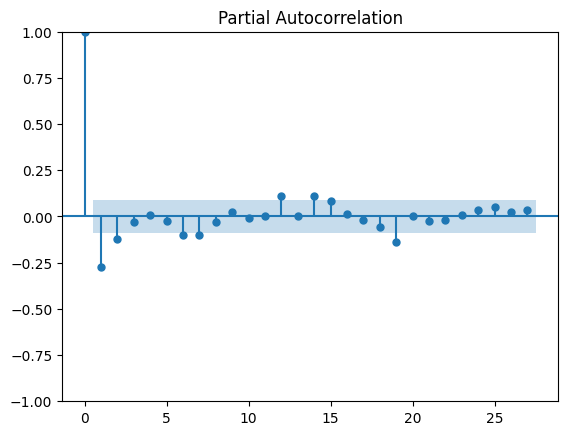

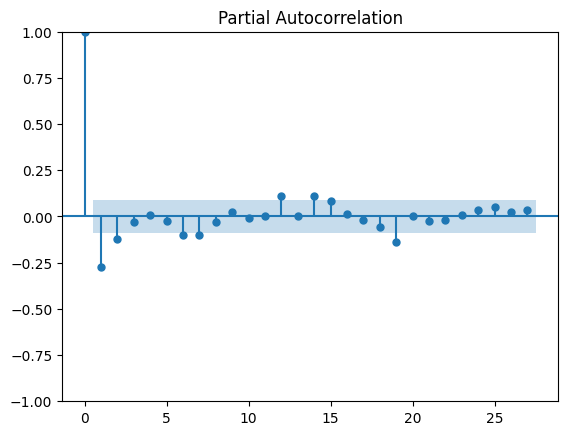

In [37]:
plot_pacf(train["seasonal_stripped"].diff().dropna())

Bu grafiklerin gerçekte ne anlama geldiğini arkadaşınızla konuşmak için zaman ayırın. Hangisi sizin `p` parametrenize karşılık geliyor ve hangisi `q` parametrenize?

Şimdi `p` `d` ve `q` değerleriniz için uygun order değerleriyle basit bir ARIMA modeli oluşturun. Model özetini inceleyin.

In [38]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train["seasonal_stripped"], order = (2,1,1))

fitted = model.fit()

fitted.summary()

/Users/dilay/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dilay/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      seasonal_stripped   No. Observations:                  475
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -107.921
Date:                Fri, 20 Feb 2026   AIC                            223.842
Time:                        16:50:57   BIC                            240.487
Sample:                    05-31-1974   HQIC                           230.388
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7212      0.043     16.934      0.000       0.638       0.805
ar.L2          0.2787      0.043      6.541      0.000       0.195       0.362
ma.L1         -0.9922      0.011    -94.485      0.000      -1.013      -0.972
sigma2         0.0917      0.006     16.357      0.000       0.081       0.103
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.37   Prob(JB):                         0.31
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Özet hakkında ne fark ediyorsunuz? Buradaki en önemli özellikler neler?

Katsayılarımıza güvenebiliriz gibi görünüyor ve ~223'lük bir AIC'miz var. Ama bu en iyi model miydi? Farklı modelleri grid search yapmak ve hangisinin en iyi AIC'ye sahip olduğunu görmek için `auto_arima` fonksiyonunu kullanmayı deneyin

In [39]:
train

,CO2 molfrac (ppm),seasonal_component,seasonal_stripped
1974-05-31,333.156923,1.008482,330.354959
1974-06-30,332.170400,1.006564,330.004173
1974-07-31,331.110000,1.001811,330.511417
1974-08-31,329.105769,0.995762,330.506354
1974-09-30,327.303182,0.990900,330.308904
...,...,...,...
2013-07-31,397.451905,1.001811,396.733388
2013-08-31,395.393704,0.995762,397.076392
2013-09-30,393.726538,0.990900,397.342246
2013-10-31,393.904286,0.990801,397.561262


In [40]:
from pmdarima.arima import auto_arima

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    auto_model = auto_arima(train["seasonal_stripped"], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=214.996, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=692.640, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=490.163, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=215.658, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=219.352, Time=0.17 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=218.954, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=218.567, Time=0.06 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 1.274 seconds


In [41]:
auto_model.aic()

214.9956291810954

En iyi AIC skorunuzu `best_AIC`'ye kaydedin

In [42]:
best_AIC = auto_model.aic()

In [43]:
from nbresult import ChallengeResult

result = ChallengeResult('score',
                         aic_score = best_AIC)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_score.py::TestScore::test_AIC_score PASSED                          [100%]

============================== 1 passed in 0.19s ===============================


💯 You can commit your code:

git add tests/score.pickle

git commit -m 'Completed score step'

git push origin master



Çoğu zaman, hangi modelin verilerimize en iyi uyacağını tahmin etmek zor olabilir, bu yüzden genellikle grid-search yapmak ve modellerimizin AIC skorlarını karşılaştırmak iyi bir fikirdir 🧐 Burada, bir __(0,1,1)__ modelinin daha iyi bir AIC skoru aldığı görünüyor (yani orijinal modelimizin MA bileşenleri muhtemelen model likelihood'ımızı o kadar iyileştirmiyordu!)

### Tahminler Yapmak (biraz Pandas çalışmasına hazır olun!)

Artik en iyi modelimize sahip olduğumuza göre, bazı tahminler ve - önemlisi - bazı güven aralıkları oluşturmak istiyoruz. Test setinizin uzunluğu için tahmin yapmak üzere modelinizi kullanın ve bu aralıkları da döndürdüğünüzden emin olun (`return_conf_int = True` kullanın). `preds`, `upper` ve `lower` sınırları için sütunlar içeren bir `preds_df` DataFrame oluşturun.

In [44]:
preds, conf = auto_model.predict(len(test), return_conf_int = True)

/Users/dilay/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dilay/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [45]:
preds_df = pd.DataFrame(preds, columns = ["preds"])

In [46]:
preds_df["lower"] = conf[:, 0]
preds_df["upper"] = conf[:, 1]


In [47]:
from nbresult import ChallengeResult

result = ChallengeResult('preds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_preds.py::TestPreds::test_df_values PASSED                          [ 50%]
test_preds.py::TestPreds::test_preds_cols PASSED                         [100%]

============================== 2 passed in 0.59s ===============================


💯 You can commit your code:

git add tests/preds.pickle

git commit -m 'Completed preds step'

git push origin master



Şimdi bunları çizdirin ve `train` verilerinizle karşılaştırıldığında nasıl göründüklerine bakın

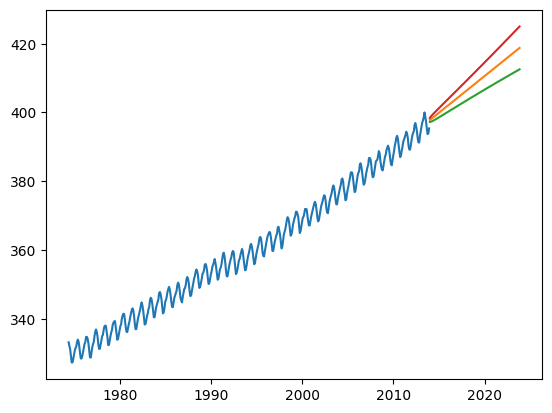

In [48]:
plt.plot(train["CO2 molfrac (ppm)"])
plt.plot(preds_df)

Bir şeyler biraz yanlış görünüyor, değil mi? Açıkça mevsimsellik olan bir şeyden çıkan üç düz çizgiye bakıyoruz. Bunu hesaba katmak için, daha önce çıkardığımız mevsimsellik bileşenini yeniden dahil etmemiz gerekiyor!

`preds_df` DataFrame'inizde bir `month` sütunu oluşturun ve bunu index'in ay bileşeniyle doldurun.

In [49]:
preds_df["month"] = preds_df.index.month

In [50]:
preds_df

,preds,lower,upper,month
2013-12-31,397.844214,397.258361,398.430066,12
2014-01-31,398.003038,397.293937,398.712139,1
2014-02-28,398.168303,397.361913,398.974692,2
2014-03-31,398.337798,397.456551,399.219045,3
2014-04-30,398.510109,397.564961,399.455257,4
...,...,...,...,...
2023-06-30,418.064320,412.036723,424.091916,6
2023-07-31,418.242185,412.162371,424.321999,7
2023-08-31,418.420050,412.287888,424.552212,8
2023-09-30,418.597915,412.413274,424.782556,9


Artık daha önce oluşturduğumuz `seasonal_one_year` DataFrame'ini alıp `preds_df`'imize basitçe merge edebiliriz!

In [51]:
train["month"] = train.index.month

In [52]:
train

,CO2 molfrac (ppm),seasonal_component,seasonal_stripped,month
1974-05-31,333.156923,1.008482,330.354959,5
1974-06-30,332.170400,1.006564,330.004173,6
1974-07-31,331.110000,1.001811,330.511417,7
1974-08-31,329.105769,0.995762,330.506354,8
1974-09-30,327.303182,0.990900,330.308904,9
...,...,...,...,...
2013-07-31,397.451905,1.001811,396.733388,7
2013-08-31,395.393704,0.995762,397.076392,8
2013-09-30,393.726538,0.990900,397.342246,9
2013-10-31,393.904286,0.990801,397.561262,10


In [53]:
preds_df = preds_df.merge(seasonal_one_year, on = "month", how = "left")

In [54]:
preds_df

,preds,lower,upper,month,seasonal_component
0,397.844214,397.258361,398.430066,12,0.997567
1,398.003038,397.293937,398.712139,1,1.000244
2,398.168303,397.361913,398.974692,2,1.002097
3,398.337798,397.456551,399.219045,3,1.004264
4,398.510109,397.564961,399.455257,4,1.007375
...,...,...,...,...,...
114,418.064320,412.036723,424.091916,6,1.006564
115,418.242185,412.162371,424.321999,7,1.001811
116,418.420050,412.287888,424.552212,8,0.995762
117,418.597915,412.413274,424.782556,9,0.990900


Şimdi `preds_df` DataFrame'inde yeni sütunlar olarak `full_preds`, `upper_conf` ve `lower_conf`'ı (`preds`, `upper` __ve__ `lower` sütunlarınızı `preds_df` DataFrame'imizde artık sahip olduğumuz mevsimsel bileşenle çarparak) oluşturabilirsiniz.

In [55]:
preds_df["full_preds"] = preds_df["preds"] * preds_df["seasonal_component"]

preds_df["lower_conf"] = preds_df["lower"] * preds_df["seasonal_component"]

preds_df["upper_conf"] = preds_df["upper"] * preds_df["seasonal_component"]

Son olarak, plotting'i bizim için kolaylaştırmak için, `preds_df`'nizin index'ini `test` DataFrame'inizin index'iyle aynı olacak şekilde ayarlayın (aynı uzunluğa sahip oldukları için bu bizim için oldukça kolay olmalı!)

In [56]:
preds_df.set_index(test.index, inplace = True)

In [57]:
from nbresult import ChallengeResult

result = ChallengeResult('fullpreds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/S17D4-S-arima-seasonal/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_fullpreds.py::TestFullpreds::test_columns PASSED                    [ 50%]
test_fullpreds.py::TestFullpreds::test_index PASSED                      [100%]

============================== 2 passed in 0.50s ===============================


💯 You can commit your code:

git add tests/fullpreds.pickle

git commit -m 'Completed fullpreds step'

git push origin master



Şimdi her şeyi çizdirin - train'inizin sonu (örneğin son 100 değer), tam tahminleriniz, üst ve alt güven sınırları ve `preds_df` DataFrame'inizden gerçek değerler __ve__ baseline'nız!

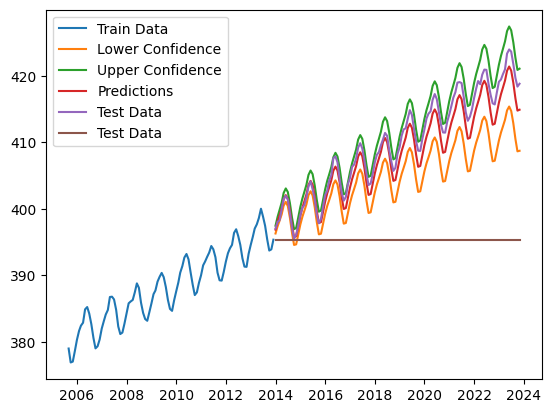

In [58]:
plt.plot(train["CO2 molfrac (ppm)"][-100:], label="Train Data")
plt.plot(preds_df["lower_conf"], label="Lower Confidence")
plt.plot(preds_df["upper_conf"], label="Upper Confidence")
plt.plot(preds_df["full_preds"], label="Predictions")
plt.plot(test, label="Test Data")
plt.legend()

plt.show()

Tahminlerimiz oldukça iyi görünüyor! Gerçek değerlerin tahmin ettiklerimizden biraz daha yüksek olduğunu görebiliyoruz ancak tahmin yapmaya başladığımız zamandan tam 10 yıl sonrası için güven aralıklarımızın sınırları içinde iyi bir şekilde kalıyor.

Neden değerlerimiz gerçek değerlerin altına düştü? Test verisini ayrıştırmak ve trend bileşenine bakmak için aşağıdaki hücreyi çalıştırın 👀


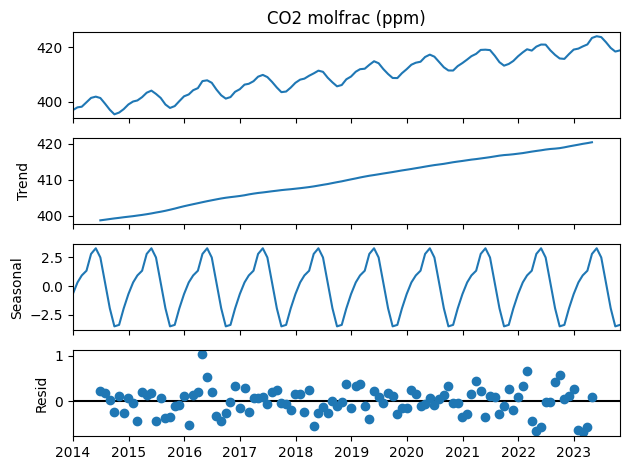

In [59]:
seasonal_decompose(test["CO2 molfrac (ppm)"]).plot();

2016-2018'de normal (biraz daha sığ) trend tekrar devralınmadan önce tüm değerlerimizde __hafif bir artis__ olduğu görünüyor. Bu, test veri setimizde basitçe tahmin edemeyeceğimiz bir şeyin meydana gelmesinin harika bir örneği. CO2 okumalarında neden bir artış olduğunu bilmiyoruz - ve bunun için tahmin yapamadık.

❗ Zaman Serisi ile modelleme yaptığımızda, __sihirli bir şekilde geleceği tahmin edemeyiz__. Yapmaya çalıştığımız şey, geçmişin desenlerini doğru bir şekilde yakalamak ve sonra bunları genişletmektir.

- Çoğu zaman, ham tahminleriniz (mevsimsel bileşen olmadan) oldukça sıkıcı düz bir çizgi gibi görünecektir 🙄 (mevcut başlangıç tahminlerimizin yaptığı gibi) ancak bu beklediğimiz bir şey
- Zaman Serisi analizi yaparken elde ettiğimiz değerin çoğu, trendlerimizi, mevsimsel bileşenlerimizi ve güven aralıklarımızı __nicelleştirebilmemizde__ yatıyor, böylece iyi bilgilendirilmiş kararlar verebiliriz ✅

Son olarak, modelimizin baseline'ımızdan ne kadar daha iyi olduğunu hızlıca nicelleyelim. `preds`'leriniz (mevsimsel bileşenleriyle birlikte) ve gerçek değerler arasındaki ortalama mutlak hatayı hesaplayın. `model_mae`'nizin orijinal `baseline_mae`'den düşük olup olmadığına bakın.

In [60]:
model_mae = (test["CO2 molfrac (ppm)"] - preds_df["full_preds"]).mean()

In [61]:
model_mae

1.5625951023958966

Final MAE'miz orijinal baseline'ımızdan __çok__ daha iyi olmalı. Harika iş 🥳 